**Emotion Detection**

In [2]:
import tensorflow as tf
import os

#gpu check
gpu_available = tf.test.is_gpu_available()
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3, 0))

print('Debug 1', gpu_available, is_cuda_gpu_available, is_cuda_gpu_min_3)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Debug 2", physical_devices)

Debug 1 True True True
Debug 2 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
%pip install gputil

import GPUtil

# Get the list of available GPUs
gpus = GPUtil.getGPUs()

if gpus:
    # Print information about each GPU
    for gpu in gpus:
        print("GPU ID:", gpu.id)
        print("GPU Name:", gpu.name)
        print("GPU Driver:", gpu.driver)
        print("GPU Memory Total:", gpu.memoryTotal, "MB")
        print("GPU Memory Free:", gpu.memoryFree, "MB")
        print("GPU Memory Used:", gpu.memoryUsed, "MB")
        print("GPU GPU Percentage:", gpu.gpu, "%")

Note: you may need to restart the kernel to use updated packages.
GPU ID: 0
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU
GPU Driver: 516.40
GPU Memory Total: 6144.0 MB
GPU Memory Free: 6023.0 MB
GPU Memory Used: 0.0 MB


AttributeError: 'GPU' object has no attribute 'gpu'

In [13]:
#import required libraries
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

#layers and processing funtions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("TF version : ", tf.__version__)

TF version :  2.10.1


image name : train\angry\PrivateTest_57176772.jpg
image name : train\neutral\PrivateTest_54767073.jpg
image name : train\happy\PublicTest_5287444.jpg
image name : train\angry\PrivateTest_92990358.jpg
image name : train\sad\PrivateTest_48762267.jpg
image name : train\sad\PrivateTest_55277524.jpg
image name : train\angry\PrivateTest_11296953.jpg
image name : train\happy\PrivateTest_99764146.jpg
image name : train\fear\PublicTest_78036016.jpg


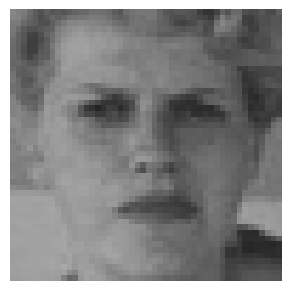

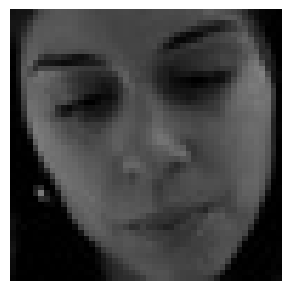

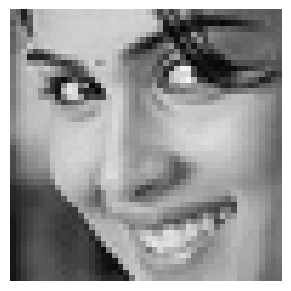

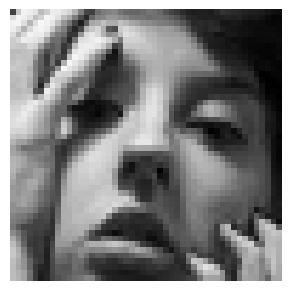

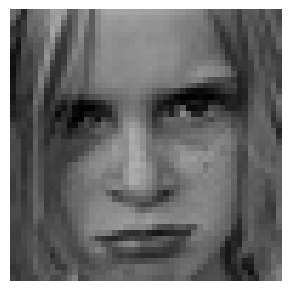

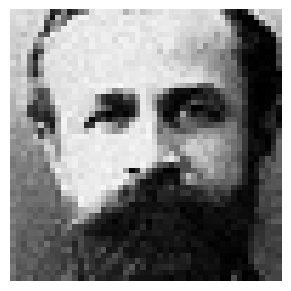

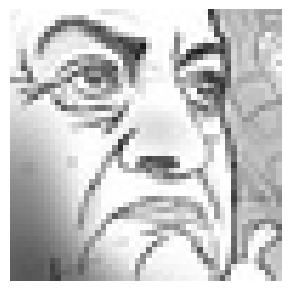

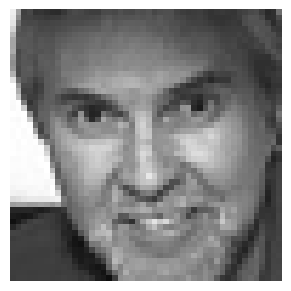

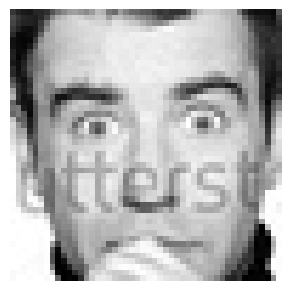

In [31]:
#labeling and uploading image data

images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    print("image name :",image)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

**preparing data for training**

In [54]:
img_size = 48
batch_size = 64

#for training
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size = (img_size,img_size),
                                                    color_mode ="grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)
#for validation
datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                    target_size = (img_size,img_size),
                                                    color_mode ="grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

Found 7178 images belonging to 7 classes.
Found 0 images belonging to 0 classes.


**Defining Model**

In [33]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size=kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    return x

In [34]:
def  Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x

In [35]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(inputs,64,(5,5))
    conv_3 = Convolution(inputs,128,(3,3))

    flatten = Flatten()(conv_3)
    dense_1 = Dense_f(flatten,256)
    output = Dense(7,activation = "softmax")(dense_1)

    model = Model(inputs=[inputs], outputs=[output])
    model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])
    return model

In [36]:
model = model_fer((48,48,1))
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 128)       1280      
                                                                 
 batch_normalization_5 (Batc  (None, 48, 48, 128)      512       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 48, 48, 128)       0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 128)       0   

**Intializing the model**

In [37]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor = 'val_accuracy', save_weights_only = True, mode = 'max', verbose = 1)
callbacks = [checkpoint]

## Training the model

In [46]:
import scipy
history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data= validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks)
    

Epoch 1/15
111/112 [============================>.] - ETA: 0s - loss: 1.8228 - accuracy: 0.2474
Epoch 1: saving model to model_weights.h5
112/112 [==============================] - 3s 24ms/step - loss: 1.8226 - accuracy: 0.2474
Epoch 2/15
112/112 [==============================] - ETA: 0s - loss: 1.8210 - accuracy: 0.2473
Epoch 2: saving model to model_weights.h5
112/112 [==============================] - 3s 25ms/step - loss: 1.8210 - accuracy: 0.2473
Epoch 3/15
111/112 [============================>.] - ETA: 0s - loss: 1.8201 - accuracy: 0.2478
Epoch 3: saving model to model_weights.h5
112/112 [==============================] - 3s 23ms/step - loss: 1.8196 - accuracy: 0.2481
Epoch 4/15
112/112 [==============================] - ETA: 0s - loss: 1.8191 - accuracy: 0.2473
Epoch 4: saving model to model_weights.h5
112/112 [==============================] - 3s 24ms/step - loss: 1.8191 - accuracy: 0.2473
Epoch 5/15
111/112 [============================>.] - ETA: 0s - loss: 1.8186 - accuracy:

**model evaluation**

In [56]:
model.evaluate(validation_generator)

ValueError: Asked to retrieve element 0, but the Sequence has length 0

**Plotting loss**

KeyError: 'val_loss'

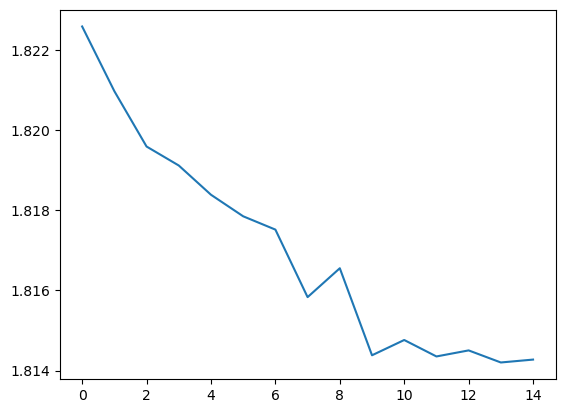

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom=0.0, right=0.95, left = 0.0, hspace = 0.25, wspace = 0.35)

## Saving model

In [15]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)